<a href="https://colab.research.google.com/github/Habibawally/Diffusion-Model-CIFAR10/blob/main/Diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# اختر خلية جديدة في Colab وشغليها
!pip install --upgrade pip
!pip install torch torchvision matplotlib
# إذا كنتِ تستخدمي GPU معين أو نسخة CUDA محددة قد تحتاجي نسخة torch المناسبة - غالبًا السطر فوق يكفي في Colab.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
import os, tqdm, random, torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn
from PIL import Image
from multiprocessing import Manager as SharedMemoryManager
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet, BasicBlock
from typing import Optional, Union, Iterable, Tuple

In [ ]:
# 1. Transformations (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # upscale CIFAR10 to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB normalization
])

In [ ]:
# 2. Download Dataset (CIFAR-10)
data_dir = "./data"
train_data = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_channels = 3
first_fmap_channels = 64
last_fmap_channels = 512 #2048
output_channels = 3
time_embedding = 256
learning_rate = 1e-4 #1e-2
min_lr = 1e-6
weight_decay = 0.0
T = 500
beta_min = 1e-4
beta_max = 2e-2
beta_scheduler = 'cosine'
batch_size = 10
n_samples = 12_000
cache_size = 12_000
image_size = (64, 64)

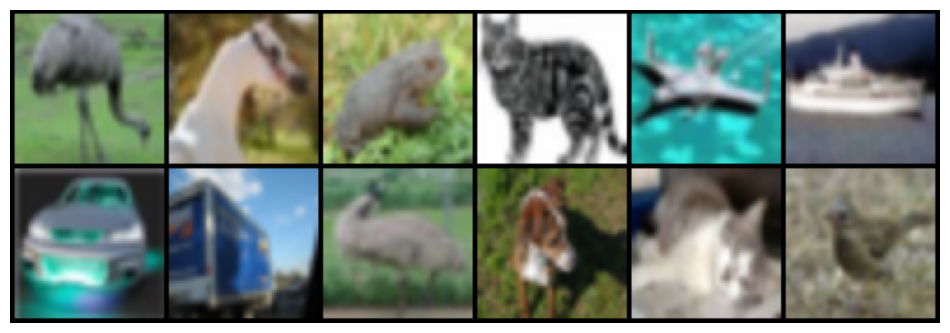

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=12, shuffle=True)

# Get one batch
images, labels = next(iter(train_loader))

# Convert to grid for visualization
grid = torchvision.utils.make_grid(images, nrow=6, normalize=True)
plt.figure(figsize=(12,6))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.show()


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, base_dataset, cache_size=1000):
        self.base_dataset = base_dataset
        self.cache_size = cache_size
        self.cache = SharedMemoryManager().dict()

    def __len__(self):
        return len(self.base_dataset)

    def _addToCache(self, idx:int, image:torch.Tensor):
        if self.cache_size > 0:
            if len(self.cache) >= self.cache_size:
                key_to_remove = random.choice(list(self.cache.keys()))
                self.cache.pop(key_to_remove)
            self.cache[idx] = image

    def __getitem__(self, idx:int):
        if idx in self.cache.keys():
            return self.cache[idx]

        image, _ = self.base_dataset[idx]
        self._addToCache(idx, image)
        return image

# إنشاء Dataset جديد مع Cache
dataset = ImageDataset(train_data, cache_size=500)

# تجربة عيّنة واحدة
sample_img = dataset[0]
print(f'shape: {sample_img.shape}')
print(f'min pixel value: {sample_img.min()}')
print(f'mean pixel value: {sample_img.mean()}')
print(f'max pixel value: {sample_img.max()}')

shape: torch.Size([3, 64, 64])
min pixel value: -0.9921568632125854
mean pixel value: -0.18678832054138184
max pixel value: 0.9764705896377563


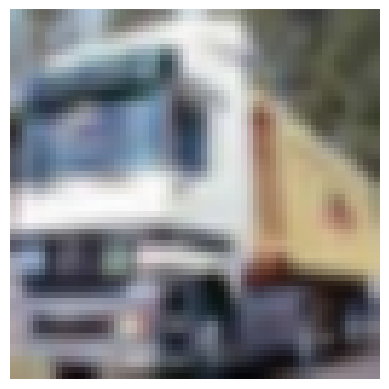

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# خدي أول صورة من الـ dataset
sample_img = dataset[1]

# حولي الـ Tensor لصورة قابلة للعرض
img_np = sample_img.permute(1, 2, 0).numpy()
img_np = (img_np * 0.5 + 0.5)  # نرجّع القيم من [-1,1] إلى [0,1]

# عرض الصورة
plt.imshow(img_np)
plt.axis('off')
plt.show()


number of images: 50000


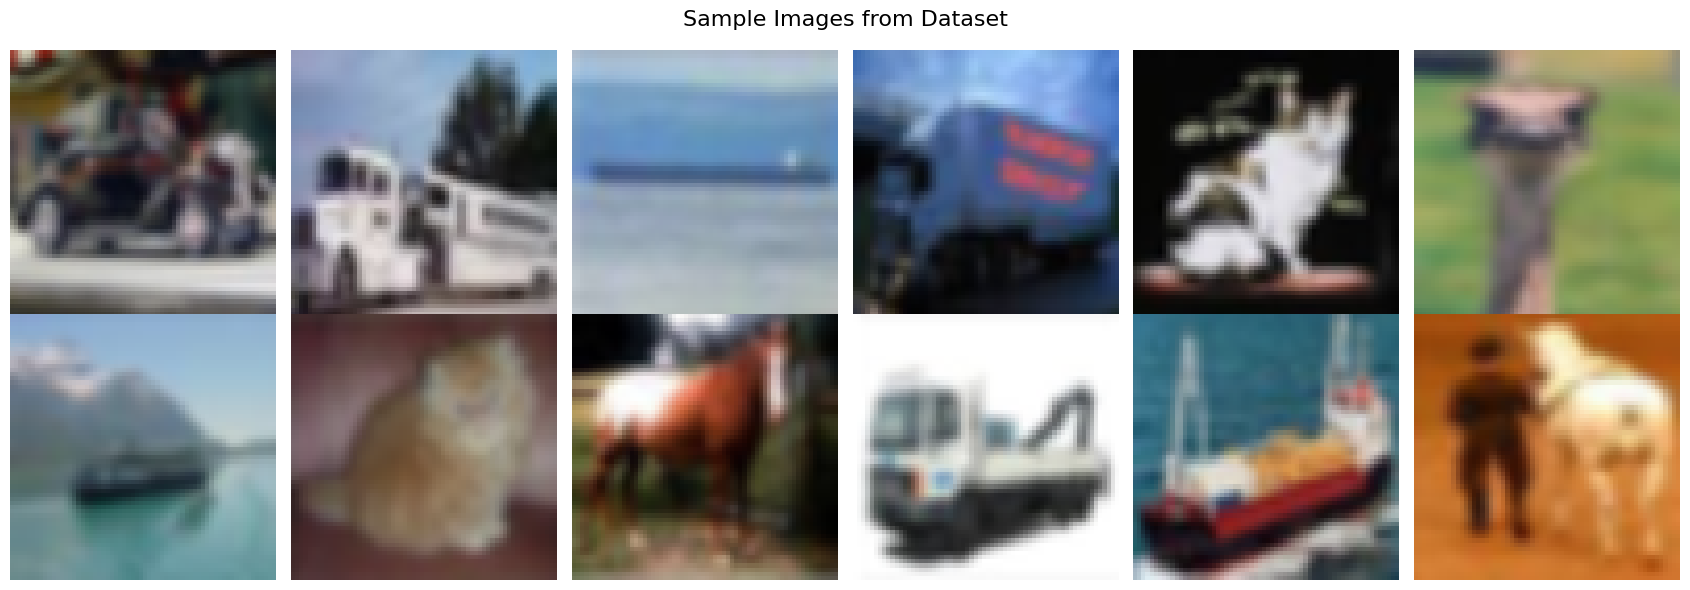

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import os
import torch

# نعرض عينات من الداتا بعد ما أنشأنا الـ dataset
print(f'number of images: {len(dataset)}')

# تحديد عدد الصفوف والأعمدة
n_rows, n_cols = 2, 6
fig, axs = plt.subplots(n_rows, n_cols, figsize=(17, 6))

for i in range(n_rows):
    for j in range(n_cols):
        idx = random.randint(0, len(dataset) - 1)
        img = dataset[idx]

        # فك الـ Normalize علشان الصورة تبقى واضحة
        img_np = img.permute(1, 2, 0).numpy()
        img_np = np.clip((img_np * 0.5 + 0.5), 0, 1)

        axs[i, j].imshow(img_np)
        axs[i, j].axis('off')

plt.suptitle('Sample Images from Dataset', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
class DiffusionUtils:
    def __init__(self, n_timesteps:int, beta_min:float, beta_max:float, device:str='cpu', scheduler:str='linear'):
        assert scheduler in ['linear', 'cosine'], 'scheduler must be linear or cosine'

        self.n_timesteps = n_timesteps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.device = device
        self.scheduler = scheduler

        self.betas = self.betaSamples()
        self.alphas = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0).to(self.device)

    def betaSamples(self):
        if self.scheduler == 'linear':
            return torch.linspace(start=self.beta_min, end=self.beta_max, steps=self.n_timesteps).to(self.device)

        elif self.scheduler == 'cosine':
            betas = []
            for i in reversed(range(self.n_timesteps)):
                T = self.n_timesteps - 1
                beta = self.beta_min + 0.5 * (self.beta_max - self.beta_min) * (1 + np.cos((i/T) * np.pi))
                betas.append(beta)
            return torch.Tensor(betas).to(self.device)

    def sampleTimestep(self, size:int):
        return torch.randint(low=1, high=self.n_timesteps, size=(size, )).to(self.device)

    def noiseImage(self, x:torch.Tensor, t:torch.LongTensor):
        assert len(x.shape) == 4, 'input must be 4D (N, C, H, W)'
        alpha_hat_sqrts = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        one_minus_alpha_hat_sqrts = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x).to(self.device)
        return (alpha_hat_sqrts * x) + (one_minus_alpha_hat_sqrts * noise), noise

    def sample(self, x:torch.Tensor, model:nn.Module):
        assert len(x.shape) == 4, 'input must be 4D (N, C, H, W)'
        model.eval()

        with torch.no_grad():
            for i in tqdm.tqdm(reversed(range(1, self.n_timesteps))):
                t = (torch.ones(x.shape[0]) * i).long().to(self.device)
                alpha = self.alphas[t][:, None, None, None]
                beta = self.betas[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat

                predicted_noise = model(x, t)

                noise = torch.randn_like(x).to(self.device) if i > 1 else torch.zeros_like(x).to(self.device)

                x = 1/torch.sqrt(alpha) * (x - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x = x + (torch.sqrt(beta) * noise)
        return x

linear beta scheduling...


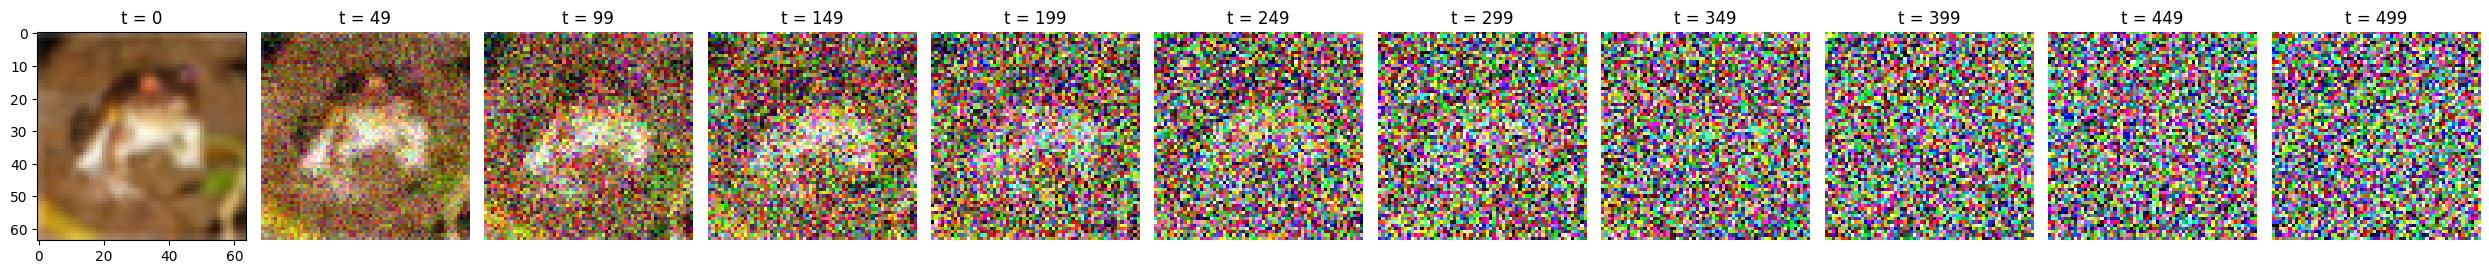



cosine beta scheduling...


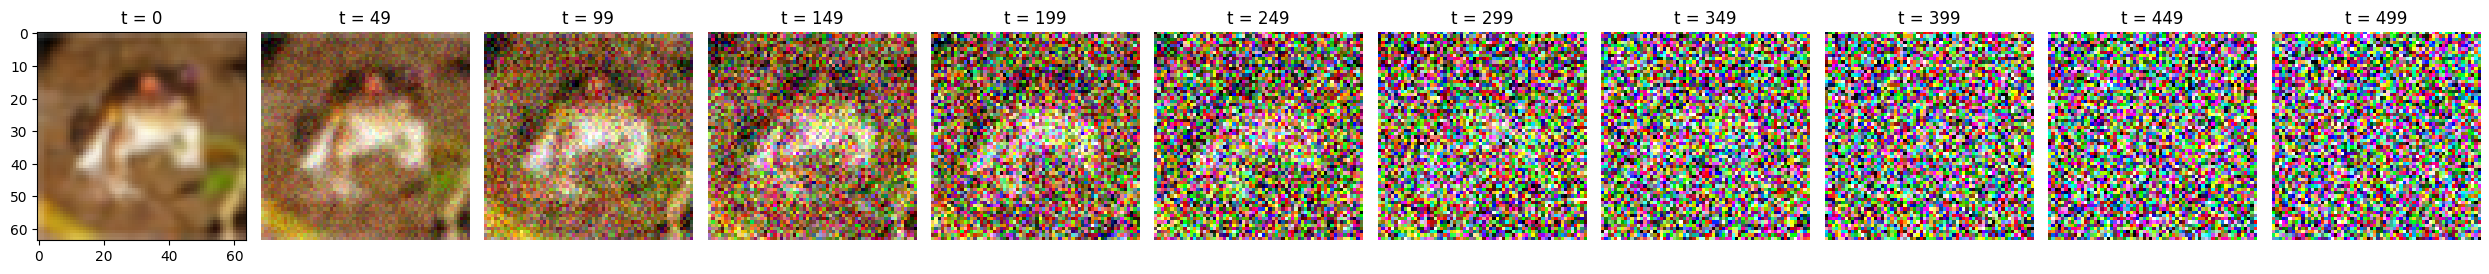

In [ ]:
alpha_values = {}
n_steps = 50

sample_img = dataset[0]  # صورة واحدة من الـ dataset
sample_img = sample_img.to('cpu')

for scheduler in ['linear', 'cosine']:
    print(f'{scheduler} beta scheduling...')
    diffusion = DiffusionUtils(T, beta_min, beta_max, scheduler=scheduler)
    alpha_values[scheduler] = diffusion.alphas

    fig, axs = plt.subplots(1, (T // n_steps) + 1, figsize=(25, 6))

    axs[0].imshow((sample_img.permute(1, 2, 0).numpy() * 0.5 + 0.5))
    axs[0].set_title('t = 0')

    for idx, t in enumerate(range(n_steps-1, T, n_steps)):
        t_tensor = torch.Tensor([t]).long()
        x_noisy, _ = diffusion.noiseImage(sample_img.unsqueeze(0), t_tensor)
        img_np = x_noisy.squeeze(0).permute(1, 2, 0).numpy()
        img_np = np.clip((img_np * 0.5 + 0.5), 0, 1)
        axs[idx+1].imshow(img_np)
        axs[idx+1].set_title(f't = {t}')
        axs[idx+1].axis('off')

    plt.tight_layout()
    plt.show()
    print('\n')

Text(0.5, 1.0, 'alpha values of cosine scheduling')

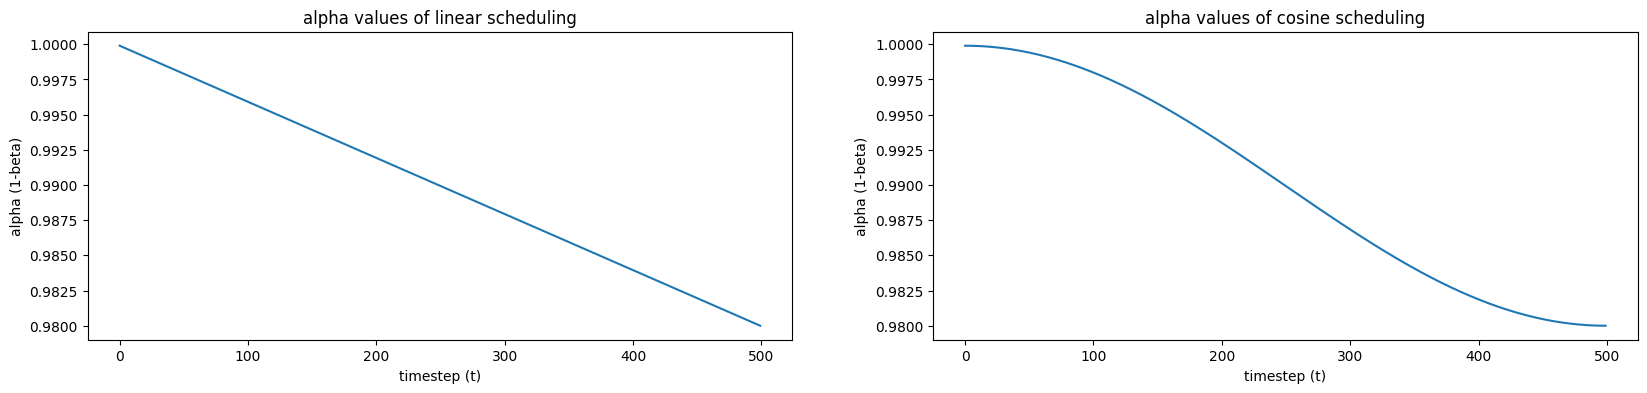

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[0].plot(alpha_values['linear'])
axs[0].set_xlabel('timestep (t)')
axs[0].set_ylabel('alpha (1-beta)')
axs[0].set_title('alpha values of linear scheduling')

axs[1].plot(alpha_values['cosine'])
axs[1].set_xlabel('timestep (t)')
axs[1].set_ylabel('alpha (1-beta)')
axs[1].set_title('alpha values of cosine scheduling')

In [ ]:
import torch
import torch.nn as nn

# Sinusoidal Embedding
class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim_size, n:int=10000):
        super(SinusoidalEmbedding, self).__init__()
        assert dim_size % 2 == 0, 'dim_size should be an even number'
        self.dim_size = dim_size
        self.n = n

    def forward(self, x:torch.Tensor):
        N = len(x)
        output = torch.zeros(size=(N, self.dim_size)).to(x.device)

        for idx in range(N):
            for i in range(0, self.dim_size // 2):
                emb = x[idx] / (self.n ** (2 * i / self.dim_size))
                output[idx, 2*i] = torch.sin(emb)
                output[idx, 2*i + 1] = torch.cos(emb)

        return output


# Image Self-Attention
class ImageSelfAttention(nn.Module):
    def __init__(self, input_channels:int, n_heads:int):
        super(ImageSelfAttention, self).__init__()

        self.input_channels = input_channels
        self.n_heads = n_heads
        self.layernorm = nn.LayerNorm(self.input_channels)
        self.attention = nn.MultiheadAttention(self.input_channels, self.n_heads, batch_first=True)

    def forward(self, x:torch.Tensor):
        # Input shape: (N, C, H, W)
        N, C, H, W = x.shape

        # Flatten spatial dimensions (H*W) → treat each pixel as a "token"
        x = x.reshape(N, C, H*W).permute(0, 2, 1)  # (N, H*W, C)

        # Apply layer normalization
        normalized_x = self.layernorm(x)

        # Self-Attention
        attn_output, _ = self.attention(normalized_x, normalized_x, normalized_x)

        # Residual connection
        attn_output = attn_output + x

        # Reshape back to image form
        attn_output = attn_output.permute(0, 2, 1).reshape(N, C, H, W)
        return attn_output


In [ ]:
import torch
import torch.nn as nn
from torchvision.models.resnet import ResNet, BasicBlock

class SinusoidalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -(torch.log(torch.tensor(10000.0)) / (half_dim - 1)))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ImageSelfAttention(nn.Module):
    def __init__(self, channels, n_heads=4):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
        self.attn = nn.MultiheadAttention(channels, n_heads, batch_first=True)

    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = x.view(B, C, H * W).permute(0, 2, 1)  # (B, N, C)
        x_norm = self.norm(x_flat)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        attn_out = attn_out.permute(0, 2, 1).view(B, C, H, W)
        return attn_out + x


# --- main Encoder based on ResNet18 backbone ---
class Encoder(ResNet):
    def __init__(self, input_channels=3, time_embedding=256, block=BasicBlock, block_layers=[2, 2, 2, 2], n_heads=4):
        super(Encoder, self).__init__(block, block_layers)

        self.input_channels = input_channels
        self.time_embedding = time_embedding
        self.n_heads = n_heads

        # Replace the first conv layer
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Delete unused layers from ResNet
        del self.maxpool, self.fc, self.avgpool

        # Sinusoidal embedding for time steps
        self.sinusoidal_embedding = SinusoidalEmbedding(self.time_embedding)

        # Define feature map channels
        fmap_channels = [64, 64, 128, 256, 512]

        # Projection layers for time embeddings
        self.time_projection_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.time_embedding, ch)
            ) for ch in fmap_channels
        ])

        # Attention layers for each feature map
        self.attention_layers = nn.ModuleList([
            ImageSelfAttention(ch, n_heads) for ch in fmap_channels
        ])

    def forward(self, x, t):
        t = self.sinusoidal_embedding(t)

        # fmap1
        fmap1 = self.conv1(x)
        t_emb = self.time_projection_layers[0](t)
        fmap1 = fmap1 + t_emb[:, :, None, None]
        fmap1 = self.attention_layers[0](fmap1)

        # fmap2
        x = self.conv2(fmap1)
        x = self.bn1(x)
        x = self.relu(x)

        fmap2 = self.layer1(x)
        t_emb = self.time_projection_layers[1](t)
        fmap2 = fmap2 + t_emb[:, :, None, None]
        fmap2 = self.attention_layers[1](fmap2)

        # fmap3
        fmap3 = self.layer2(fmap2)
        t_emb = self.time_projection_layers[2](t)
        fmap3 = fmap3 + t_emb[:, :, None, None]
        fmap3 = self.attention_layers[2](fmap3)

        # fmap4
        fmap4 = self.layer3(fmap3)
        t_emb = self.time_projection_layers[3](t)
        fmap4 = fmap4 + t_emb[:, :, None, None]
        fmap4 = self.attention_layers[3](fmap4)

        # fmap5
        fmap5 = self.layer4(fmap4)
        t_emb = self.time_projection_layers[4](t)
        fmap5 = fmap5 + t_emb[:, :, None, None]
        fmap5 = self.attention_layers[4](fmap5)

        return fmap1, fmap2, fmap3, fmap4, fmap5


In [ ]:
import torch
import torch.nn as nn
from typing import Optional

# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(
        self, input_channels:int, output_channels:int,
        time_embedding:int, upsample_scale:int=2, activation:nn.Module=nn.ReLU,
        compute_attn:bool=True, n_heads:int=4
    ):
        super(DecoderBlock, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.upsample_scale = upsample_scale
        self.time_embedding = time_embedding
        self.compute_attn = compute_attn
        self.n_heads = n_heads

        # optional attention
        if self.compute_attn:
            self.attention = ImageSelfAttention(self.output_channels, self.n_heads)
        else:
            self.attention = nn.Identity()

        # time embedding layers
        self.sinusoidal_embedding = SinusoidalEmbedding(self.time_embedding)
        self.time_projection_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(self.time_embedding, self.output_channels)
        )

        # upsampling + conv
        self.transpose = nn.ConvTranspose2d(
            self.input_channels, self.input_channels,
            kernel_size=self.upsample_scale, stride=self.upsample_scale
        )

        self.instance_norm1 = nn.InstanceNorm2d(self.transpose.in_channels)

        self.conv = nn.Conv2d(
            self.transpose.out_channels, self.output_channels,
            kernel_size=3, stride=1, padding=1
        )

        self.instance_norm2 = nn.InstanceNorm2d(self.conv.out_channels)
        self.activation = activation()

    def forward(self, fmap:torch.Tensor, prev_fmap:Optional[torch.Tensor]=None, t:Optional[torch.Tensor]=None):
        output = self.transpose(fmap)
        output = self.instance_norm1(output)
        output = self.conv(output)
        output = self.instance_norm2(output)

        # residual connection
        if torch.is_tensor(prev_fmap):
            assert prev_fmap.shape == output.shape, 'Feature maps must have the same shape'
            output = output + prev_fmap

        # add timestep embedding
        if torch.is_tensor(t):
            t = self.sinusoidal_embedding(t)
            t_emb = self.time_projection_layer(t)
            output = output + t_emb[:, :, None, None]

        output = self.attention(output)
        output = self.activation(output)
        return output


# --- Decoder ---
class Decoder(nn.Module):
    def __init__(
        self, last_fmap_channels:int, output_channels:int,
        time_embedding:int, first_fmap_channels:int=64, n_heads:int=4
    ):
        super(Decoder, self).__init__()

        self.last_fmap_channels = last_fmap_channels
        self.output_channels = output_channels
        self.time_embedding = time_embedding
        self.first_fmap_channels = first_fmap_channels
        self.n_heads = n_heads

        # define upsampling decoder structure
        self.residual_layers = self.make_layers()

        self.final_layer = DecoderBlock(
            input_channels=self.residual_layers[-1].output_channels,
            output_channels=self.output_channels,
            time_embedding=self.time_embedding,
            activation=nn.Identity,
            compute_attn=False,
            n_heads=self.n_heads
        )

        # remove normalization for final layer
        self.final_layer.instance_norm2 = nn.Identity()

    def make_layers(self):
        layers = []
        chs = [512, 256, 128, 64, self.first_fmap_channels]
        for i in range(len(chs) - 1):
            layer = DecoderBlock(
                input_channels=chs[i],
                output_channels=chs[i + 1],
                time_embedding=self.time_embedding,
                compute_attn=True if i < 3 else False,  # attention only for deeper layers
                n_heads=self.n_heads
            )
            layers.append(layer)
        return nn.ModuleList(layers)

    def forward(self, *fmaps, t:Optional[torch.Tensor]=None):
        # input: fmap5, fmap4, fmap3, fmap2, fmap1
        fmaps = [fmap for fmap in reversed(fmaps)]

        output = None
        for idx, layer in enumerate(self.residual_layers):
            if idx == 0:
                output = layer(fmaps[idx], fmaps[idx+1], t)
            else:
                if idx + 1 < len(fmaps):
                    output = layer(output, fmaps[idx+1], t)
                else:
                    output = layer(output, None, t)

        output = self.final_layer(output, None, t)
        return output


In [ ]:
import torch
import torch.nn as nn

class DiffusionNet(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super(DiffusionNet, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # Pass input image and timestep through encoder
        enc_fmaps = self.encoder(x, t=t)

        # Decode to reconstruct (or denoise) the image
        output = self.decoder(*enc_fmaps, t=t)

        return output


In [ ]:
class TrainingPipeline:
    def __init__(self, model, lossfunc, optimizer, diffusion_utils,
                 device='cpu', weight_init=True, custom_weight_initializer=None):

        self.device = device
        self.model = model.to(self.device)
        self.lossfunc = lossfunc
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.diffusion_utils = diffusion_utils
        self.custom_weight_initializer = custom_weight_initializer

        if self.weight_init:
            if self.custom_weight_initializer:
                self.model.apply(self.custom_weight_initializer)
            else:
                self.model.apply(self.xavier_init_weights)

    def xavier_init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

    def save_model(self, dirname='./model_params', filename='DDPM.pth.tar'):
        if not os.path.isdir(dirname):
            os.mkdir(dirname)
        state_dicts = {
            'network_params': self.model.state_dict(),
            'optimizer_params': self.optimizer.state_dict(),
        }
        torch.save(state_dicts, os.path.join(dirname, filename))
        print(f'Model saved at {os.path.join(dirname, filename)}')

    def train(self, dataloader, verbose=False):
        self.model.train()
        total_loss = 0.0
        for idx, images in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
            self.model.zero_grad()
            images = images.to(self.device)

            t = self.diffusion_utils.sampleTimestep(size=images.shape[0])
            x_t, noise = self.diffusion_utils.noiseImage(images, t)
            pred_noise = self.model(x_t, t)

            batch_loss = self.lossfunc(pred_noise, noise)
            batch_loss.backward()
            self.optimizer.step()

            total_loss += batch_loss.item()

        avg_loss = total_loss / (idx + 1)
        if verbose:
            print(f'Training Loss: {avg_loss:.6f}')
        return avg_loss

# Example setup:
# train_dataset = ImageDataset(data_dir, image_size, n_samples, cache_size)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
n_timesteps = 1000

# --- Encoder, Decoder, and DiffusionNet initialization ---
encoder = Encoder(
    input_channels=input_channels,
    time_embedding=time_embedding,
    block_layers=[2, 2, 2, 2]
)

decoder = Decoder(
    last_fmap_channels=last_fmap_channels,
    output_channels=output_channels,
    time_embedding=time_embedding,
    first_fmap_channels=first_fmap_channels
)

model = DiffusionNet(encoder, decoder)

# --- Diffusion utilities initialization ---
diffusion_utils = DiffusionUtils(
    n_timesteps=n_timesteps,
    beta_min=beta_min,
    beta_max=beta_max,
    device=device,
    scheduler=beta_scheduler
)

# --- Loss function, optimizer, and pipeline initialization ---
lossfunc = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
pipeline = TrainingPipeline(model, lossfunc, optimizer, diffusion_utils, device, weight_init=True)

# --- Load pretrained weights if available ---
checkpoint_path = '/kaggle/input/ddpm-model-params/model_params/DDPM.pth.tar'
if os.path.isfile(checkpoint_path):
    checkpoint_state = torch.load(checkpoint_path, map_location=device)['network_params']
    pipeline.model.load_state_dict(checkpoint_state)
    print(" Pretrained model loaded successfully!")
else:
    print(" No pretrained weights found, starting from scratch...")

⚠️ No pretrained weights found, starting from scratch...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


✅ Test output shape: torch.Size([2, 3, 64, 64])
Total parameters in model: 16,532,102
Model is training on GPU: Tesla T4 




🌀 Epoch: 1/20


100%|██████████| 5000/5000 [04:20<00:00, 19.16it/s]


Training Loss: 0.169259

📉 Training loss: 0.169259
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 1


🌀 Epoch: 2/20


100%|██████████| 5000/5000 [04:19<00:00, 19.23it/s]


Training Loss: 0.052810

📉 Training loss: 0.052810
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 2


🌀 Epoch: 3/20


100%|██████████| 5000/5000 [04:20<00:00, 19.18it/s]


Training Loss: 0.042138

📉 Training loss: 0.042138
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 3


🌀 Epoch: 4/20


100%|██████████| 5000/5000 [04:20<00:00, 19.18it/s]


Training Loss: 0.037715

📉 Training loss: 0.037715
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 4


🌀 Epoch: 5/20


100%|██████████| 5000/5000 [04:19<00:00, 19.25it/s]


Training Loss: 0.034113

📉 Training loss: 0.034113
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 5


🌀 Epoch: 6/20


100%|██████████| 5000/5000 [04:34<00:00, 18.24it/s]


Training Loss: 0.031633

📉 Training loss: 0.031633
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 6


🌀 Epoch: 7/20


100%|██████████| 5000/5000 [04:18<00:00, 19.34it/s]


Training Loss: 0.028877

📉 Training loss: 0.028877
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 7


🌀 Epoch: 8/20


100%|██████████| 5000/5000 [04:21<00:00, 19.15it/s]


Training Loss: 0.028006

📉 Training loss: 0.028006
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 8


🌀 Epoch: 9/20


100%|██████████| 5000/5000 [04:21<00:00, 19.14it/s]


Training Loss: 0.026176

📉 Training loss: 0.026176
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 9


🌀 Epoch: 10/20


100%|██████████| 5000/5000 [04:20<00:00, 19.16it/s]


Training Loss: 0.024952

📉 Training loss: 0.024952
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 10
🎨 Generating samples...


999it [00:10, 96.34it/s]


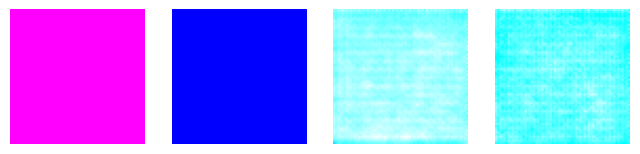



🌀 Epoch: 11/20


100%|██████████| 5000/5000 [04:20<00:00, 19.22it/s]


Training Loss: 0.024107

📉 Training loss: 0.024107
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 11


🌀 Epoch: 12/20


100%|██████████| 5000/5000 [04:21<00:00, 19.15it/s]


Training Loss: 0.023299

📉 Training loss: 0.023299
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 12


🌀 Epoch: 13/20


100%|██████████| 5000/5000 [04:22<00:00, 19.08it/s]


Training Loss: 0.022909

📉 Training loss: 0.022909
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 13


🌀 Epoch: 14/20


100%|██████████| 5000/5000 [04:20<00:00, 19.18it/s]


Training Loss: 0.022048

📉 Training loss: 0.022048
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 14


🌀 Epoch: 15/20


100%|██████████| 5000/5000 [04:20<00:00, 19.20it/s]


Training Loss: 0.021746

📉 Training loss: 0.021746
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 15


🌀 Epoch: 16/20


100%|██████████| 5000/5000 [04:22<00:00, 19.08it/s]


Training Loss: 0.021126

📉 Training loss: 0.021126
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 16


🌀 Epoch: 17/20


100%|██████████| 5000/5000 [04:23<00:00, 18.96it/s]


Training Loss: 0.020854

📉 Training loss: 0.020854
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 17


🌀 Epoch: 18/20


100%|██████████| 5000/5000 [04:21<00:00, 19.12it/s]


Training Loss: 0.020659

📉 Training loss: 0.020659
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 18


🌀 Epoch: 19/20


100%|██████████| 5000/5000 [04:20<00:00, 19.22it/s]


Training Loss: 0.020658

📉 Training loss: 0.020658
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 19


🌀 Epoch: 20/20


100%|██████████| 5000/5000 [04:19<00:00, 19.25it/s]


Training Loss: 0.020206

📉 Training loss: 0.020206
Model saved at ./model_params/DDPM.pth.tar
💾 Model saved at epoch 20
🎨 Generating samples...


999it [00:10, 90.84it/s]


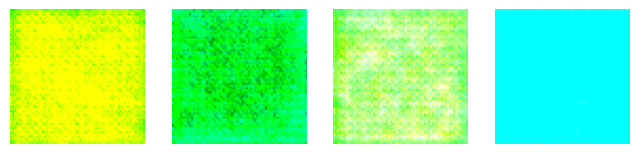

In [ ]:
# --- Learning rate scheduler ---
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    pipeline.optimizer,
    T_max=epochs,
    eta_min=min_lr
)

test_input = torch.randn(2, 3, *image_size).to(device)
t_test = torch.Tensor([2, 5]).to(device)
test_output = pipeline.model(test_input, t_test)
print(" Test output shape:", test_output.shape)

# --- Count total model parameters ---
num_params = sum(p.numel() for p in pipeline.model.parameters())
print(f"Total parameters in model: {num_params:,}")

# --- Device info ---
if torch.cuda.is_available():
    print(f"Model is training on GPU: {torch.cuda.get_device_name()} \n\n")
else:
    print("⚠️ Training on CPU")

# --- Fixed ImageDataset for Colab ---
from torch.utils.data import Dataset, DataLoader
import random

class ImageDataset(Dataset):
    def __init__(self, base_dataset, cache_size=500):
        self.base_dataset = base_dataset
        self.cache_size = cache_size
        self.cache = {}  # simple local cache (no multiprocessing)

    def __len__(self):
        return len(self.base_dataset)

    def _addToCache(self, idx:int, image:torch.Tensor):
        if self.cache_size > 0:
            if len(self.cache) >= self.cache_size:
                key_to_remove = random.choice(list(self.cache.keys()))
                self.cache.pop(key_to_remove, None)
            self.cache[idx] = image

    def __getitem__(self, idx:int):
        if idx in self.cache:
            return self.cache[idx]

        image, _ = self.base_dataset[idx]
        self._addToCache(idx, image)
        return image

# --- Dataset & Dataloader ---
train_dataset = ImageDataset(base_dataset=train_data, cache_size=500)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

# --- Training Loop ---
train_losses = []
best_loss = float("inf")

for epoch in range(epochs):
    print(f"\n\n🌀 Epoch: {epoch+1}/{epochs}")

    # Train
    train_loss = pipeline.train(train_dataloader, verbose=True)
    train_losses.append(train_loss)

    print(f"\n📉 Training loss: {train_loss:.6f}")

    # Save best model
    if train_loss < best_loss:
        best_loss = train_loss
        pipeline.save_model()
        print(f"💾 Model saved at epoch {epoch+1}")

    # Generate samples every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == (epochs - 1):
        print("🎨 Generating samples...")
        n = 4
        x = torch.randn(n, 3, *image_size).to(device)
        generated_images = diffusion_utils.sample(x, pipeline.model)
        generated_images = (generated_images.clamp(-1, 1) + 1) / 2
        generated_images = generated_images.cpu()

        fig, axs = plt.subplots(1, n, figsize=(8, 3))
        for i in range(n):
            img = generated_images[i].permute(1, 2, 0).numpy() * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            axs[i].axis('off')
        plt.show()

    # Step learning rate
    lr_scheduler.step()


✅ Model loaded successfully — ready to generate samples!
🎨 Generating samples...


999it [00:10, 94.76it/s]


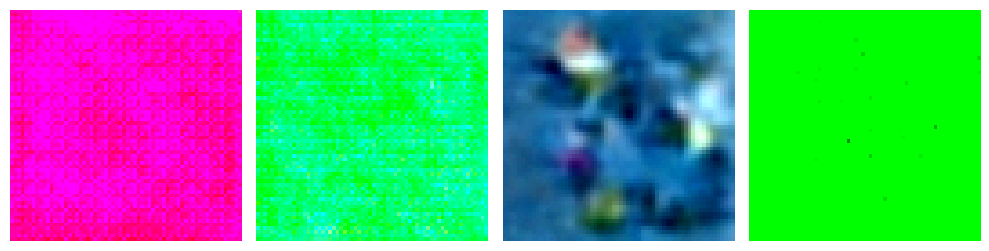

In [ ]:
import torch
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join('./model_params', 'DDPM.pth.tar')

# تأكد إن الملف موجود
if not os.path.exists(best_model_path):
    raise FileNotFoundError("Model file not found. تأكد إنك دربته قبل كده!")

checkpoint = torch.load(best_model_path, map_location=device)

if 'network_params' in checkpoint:
    best_model_state = checkpoint['network_params']
else:
    best_model_state = checkpoint

# تحميل المعلمات في الموديل
pipeline.model.load_state_dict(best_model_state)
pipeline.model.to(device)
pipeline.model.eval()
print("✅ Model loaded successfully — ready to generate samples!")

# --- توليد صور جديدة ---
print("🎨 Generating samples...")
n = 4
# ضوضاء ابتدائية عشوائية
x = torch.randn(n, 3, *image_size).to(device)

# عملية التوليد
generated_images = diffusion_utils.sample(x, pipeline.model)
generated_images = generated_images.cpu()

generated_images = (generated_images.clamp(-1, 1) + 1) / 2

fig, axs = plt.subplots(1, n, figsize=(10, 3))
for i in range(n):
    img = generated_images[i].permute(1, 2, 0) * 255
    img = img.type(torch.uint8)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.tight_layout()
plt.show()
